In [1]:
### This script is used to perform end to end training of autoencoder and HiTS.

In [32]:
import torch.nn as nn
import torch.optim as optim
import os
import sys
import torch
import numpy as np
import warnings
warnings.filterwarnings('ignore')
module_path = os.path.abspath(os.path.join('../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)
from Autoencoder import *
import ResNet as net
import matplotlib.pyplot as plt
from utils import *

In [33]:
# adjustables
k = list(range(11))            # model index: should be in {0, 2, ..., 10}
dt = 0.01                    # time unit: 0.0005 for Lorenz and 0.01 for others
system = 'FHN'         # system name: ""FHN","
noise = 0.0                    #noise levels: 0.0, 0.01, 0.02, 0.05 ,0.1, 0.2
n=100
lr = 1e-3                     # learning rate
max_epoch = 10000            # the maximum training epoch
            # training batch size
# arch = [200, 128, 64,4, 128,64, 200]  # architecture of the neural network (check paper for details)

In [34]:
# paths
data_dir = os.path.join('../data/', system)
model_dir = os.path.join('../models/', system)
path_to_result=os.path.join('../results/', system)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# global const
n_forward = 5

In [35]:
train_data = torch.load(data_dir + "/train_data.pt")
train_data = train_data.to(torch.float32).to(device)
val_data = torch.load(data_dir + "/val_data.pt")
test_data = torch.load(data_dir + "/test_data.pt")
T1=train_data.shape[1]-1
T2=2*T1
T3=3*T1
T5=5*T1
T7=7*T1
T10=10*T1

### Define Models

In [36]:
#Define AE model
input_size= train_data.shape[2]
l1= 100
l2= 100
hidden_size= 2
modelAE = AE(L1=l1, L2=l2, L3=l2, input_size=input_size, hidden_size=hidden_size).to(device)


#Define ResNet model
n= hidden_size
L1= 128
L2= 128

batch_size=train_data.shape[0]


# Define loss functions
reconstruction_loss = nn.MSELoss()
time_estimation_loss = nn.MSELoss()


# Define optimizer

step_sizes= [1,2,4,8,16,32,64,128,256,512,1024]



### Training 

In [47]:
# Training loop
num_epochs = 2000
models=list()
# best_loss = 1e+5

losses = []
#Training loop
for step_size in step_sizes:
    best_loss = 1e+5
    modelRN= net.ResNet(arch=[n, L1, L2, L1, n], dt=dt, step_size=step_size).to(device)
    AE_ResNet = nn.ModuleList(modules=[modelAE, modelRN]).to(device)
    optimizer = optim.Adam(AE_ResNet.parameters(), lr=0.0001)
    model_path='../models/FHN/AERN_{}_{}.pt'.format(hidden_size,step_size)
    for epoch in range(num_epochs):
        total_loss = 0.0
        for data in train_data:
            # Forward pass of AE
            latent, reconstructed = AE_ResNet[0](data)
            reconstruction_loss_value = reconstruction_loss(data, reconstructed)
            #Forward pass of RN
            dataset = DataSet_modified(torch.unsqueeze(latent,0), dt, step_size=step_size, n_forward=5)
            n_samples = dataset.n_train
            new_idxs = torch.randperm(n_samples)
            batch_x = dataset.train_x[new_idxs[:batch_size], :].to(device)
            batch_ys = dataset.train_ys[new_idxs[:batch_size], :, :].to(device)
            time_estimation_loss_value = modelRN.calculate_loss(batch_x, batch_ys, w=1.0)

            # estimated = AE_ResNet[1](latent)
            # Compute losses
            total_loss = 0.2*reconstruction_loss_value + 0.8*time_estimation_loss_value
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()
            # if epoch % 2 == 0:
                # print('epoch {}, reconstruction loss {}, estimation loss {}, total loss {}'.format(epoch, reconstruction_loss_value.item(),
                #                                                                   time_estimation_loss_value.item(),total_loss.item()))
        print(
            f"Epoch: {epoch + 1}/{num_epochs}, Reconstruction Loss: {reconstruction_loss_value.item()}, Time Estimation Loss: {time_estimation_loss_value.item()}, Total Loss: {total_loss.item()}")
        losses.append(total_loss.item())
        #save model
        if total_loss.item() < best_loss:
            best_loss = total_loss.item()
                # if model_path is not None:
            print('(--> new model saved @ epoch {})'.format(epoch+1))
            torch.save(AE_ResNet.state_dict(),model_path)
            models.append(AE_ResNet)
            # Backpropagation and optimization


        if total_loss <= 1e-8:
            print('--> model has reached an accuracy of 1e-8! Finished training!')
            break

## Load trained models

In [39]:
models = list()
for step_size in step_sizes:
    modelAE = AE(L1=l1, L2=l2, L3=l2, input_size=input_size, hidden_size=hidden_size).to(device)
    modelRN= net.ResNet(arch=[n, L1, L2, L1, n], dt=dt, step_size=step_size).to(device)
    AE_ResNet = nn.ModuleList(modules=[modelAE, modelRN]).to(device)
    print('models/FHN/AERN_{}_{}.pt'.format(hidden_size,step_size))
    state_dict = torch.load(os.path.join(model_dir, 'AERN_{}_{}.pt'.format(hidden_size,step_size)))
    AE_ResNet.load_state_dict(state_dict)
    models.append(AE_ResNet)

models/FHN/AERN_2_1.pt
models/FHN/AERN_2_2.pt
models/FHN/AERN_2_4.pt
models/FHN/AERN_2_8.pt
models/FHN/AERN_2_16.pt
models/FHN/AERN_2_32.pt
models/FHN/AERN_2_64.pt
models/FHN/AERN_2_128.pt
models/FHN/AERN_2_256.pt
models/FHN/AERN_2_512.pt
models/FHN/AERN_2_1024.pt


In [49]:
models[0][1]

ResNet(
  (activation): ReLU()
  (increment): NNBlock(
    (activation): ReLU()
    (Linear_0): Linear(in_features=2, out_features=128, bias=True)
    (Linear_1): Linear(in_features=128, out_features=128, bias=True)
    (Linear_2): Linear(in_features=128, out_features=128, bias=True)
    (Linear_3): Linear(in_features=128, out_features=2, bias=True)
  )
)

### Testing

In [54]:
# Testing phase
t_test=T1
n_steps=t_test
criterion = torch.nn.MSELoss(reduction='none')
test_dataAE = torch.tensor(test_data[:,:t_test,:]).to(torch.float32).to(device)
preds_mse=list()
AE_test_loss=[]
AE_test_loss_mse=list()
RN_test_loss=[]
RN_test_loss_mse=list()
x_reconstructed=[]
AEResNet_loss=[]
AEResNet_loss_mse=list()
preds=list
with torch.no_grad():
    test_loss = 0.0
    # for test_data in test_data:
    for model,step_size in zip(models,step_sizes):
        z_test, test_reconstructed = model[0](test_dataAE)
        test_data_loss = 0.0
        # AE_test_loss = reconstruction_loss(test_dataAE, test_reconstructed)
        AE_loss=criterion(torch.tensor(test_dataAE).float(), torch.tensor(test_reconstructed).float()).mean(-1)
        AE_test_loss.append(AE_loss)
        AE_test_loss_mse.append(AE_loss.mean())
        modelRN= net.ResNet(arch=[n, L1, L2, L1, n], dt=dt, step_size=step_size).to(device)
        z_RN =model[1].uni_scale_forecast(torch.tensor(z_test[:, 0, :]).float(), n_steps=n_steps).to(device)
        RN_loss=criterion(torch.tensor(z_test).float(), torch.tensor(z_RN).float()).mean(-1)
        RN_test_loss.append(RN_loss)
        RN_test_loss_mse.append(RN_loss.mean())
        x_reconstructed=(model[0].decoder(z_RN))
        AERN_loss=criterion(torch.tensor(test_dataAE).float(), torch.tensor(x_reconstructed).float()).mean(-1)
        AEResNet_loss.append(AERN_loss)
        AEResNet_loss_mse.append(AERN_loss.mean())
        print(f"AE Loss: {AE_loss.mean().item()}, ResNet Loss: {RN_loss.mean().item()}, AEResNet Loss: {AERN_loss.mean().item()}")

AE Loss: 7.186335551523371e-06, ResNet Loss: nan, AEResNet Loss: nan
AE Loss: 5.876944669580553e-06, ResNet Loss: 0.9192106127738953, AEResNet Loss: 0.21648356318473816
AE Loss: 0.1493154615163803, ResNet Loss: 7.506281004047525e+22, AEResNet Loss: 1.459565270047528e+20
AE Loss: 0.1493154615163803, ResNet Loss: 4.496098209289994e+17, AEResNet Loss: 500403586203648.0
AE Loss: 0.1493154615163803, ResNet Loss: 262311.84375, AEResNet Loss: 382.8785705566406
AE Loss: 0.1493154615163803, ResNet Loss: 37.211875915527344, AEResNet Loss: 0.2212560623884201
AE Loss: 0.1493154615163803, ResNet Loss: 90.27232360839844, AEResNet Loss: 0.34975534677505493
AE Loss: 0.1493154615163803, ResNet Loss: 1.1076122522354126, AEResNet Loss: 0.1510465145111084
AE Loss: 0.1493154615163803, ResNet Loss: 0.5660529732704163, AEResNet Loss: 0.1504521369934082
AE Loss: 0.1493154615163803, ResNet Loss: 0.03623005747795105, AEResNet Loss: 0.14937645196914673
AE Loss: 0.1493154615163803, ResNet Loss: 0.0376873724162578

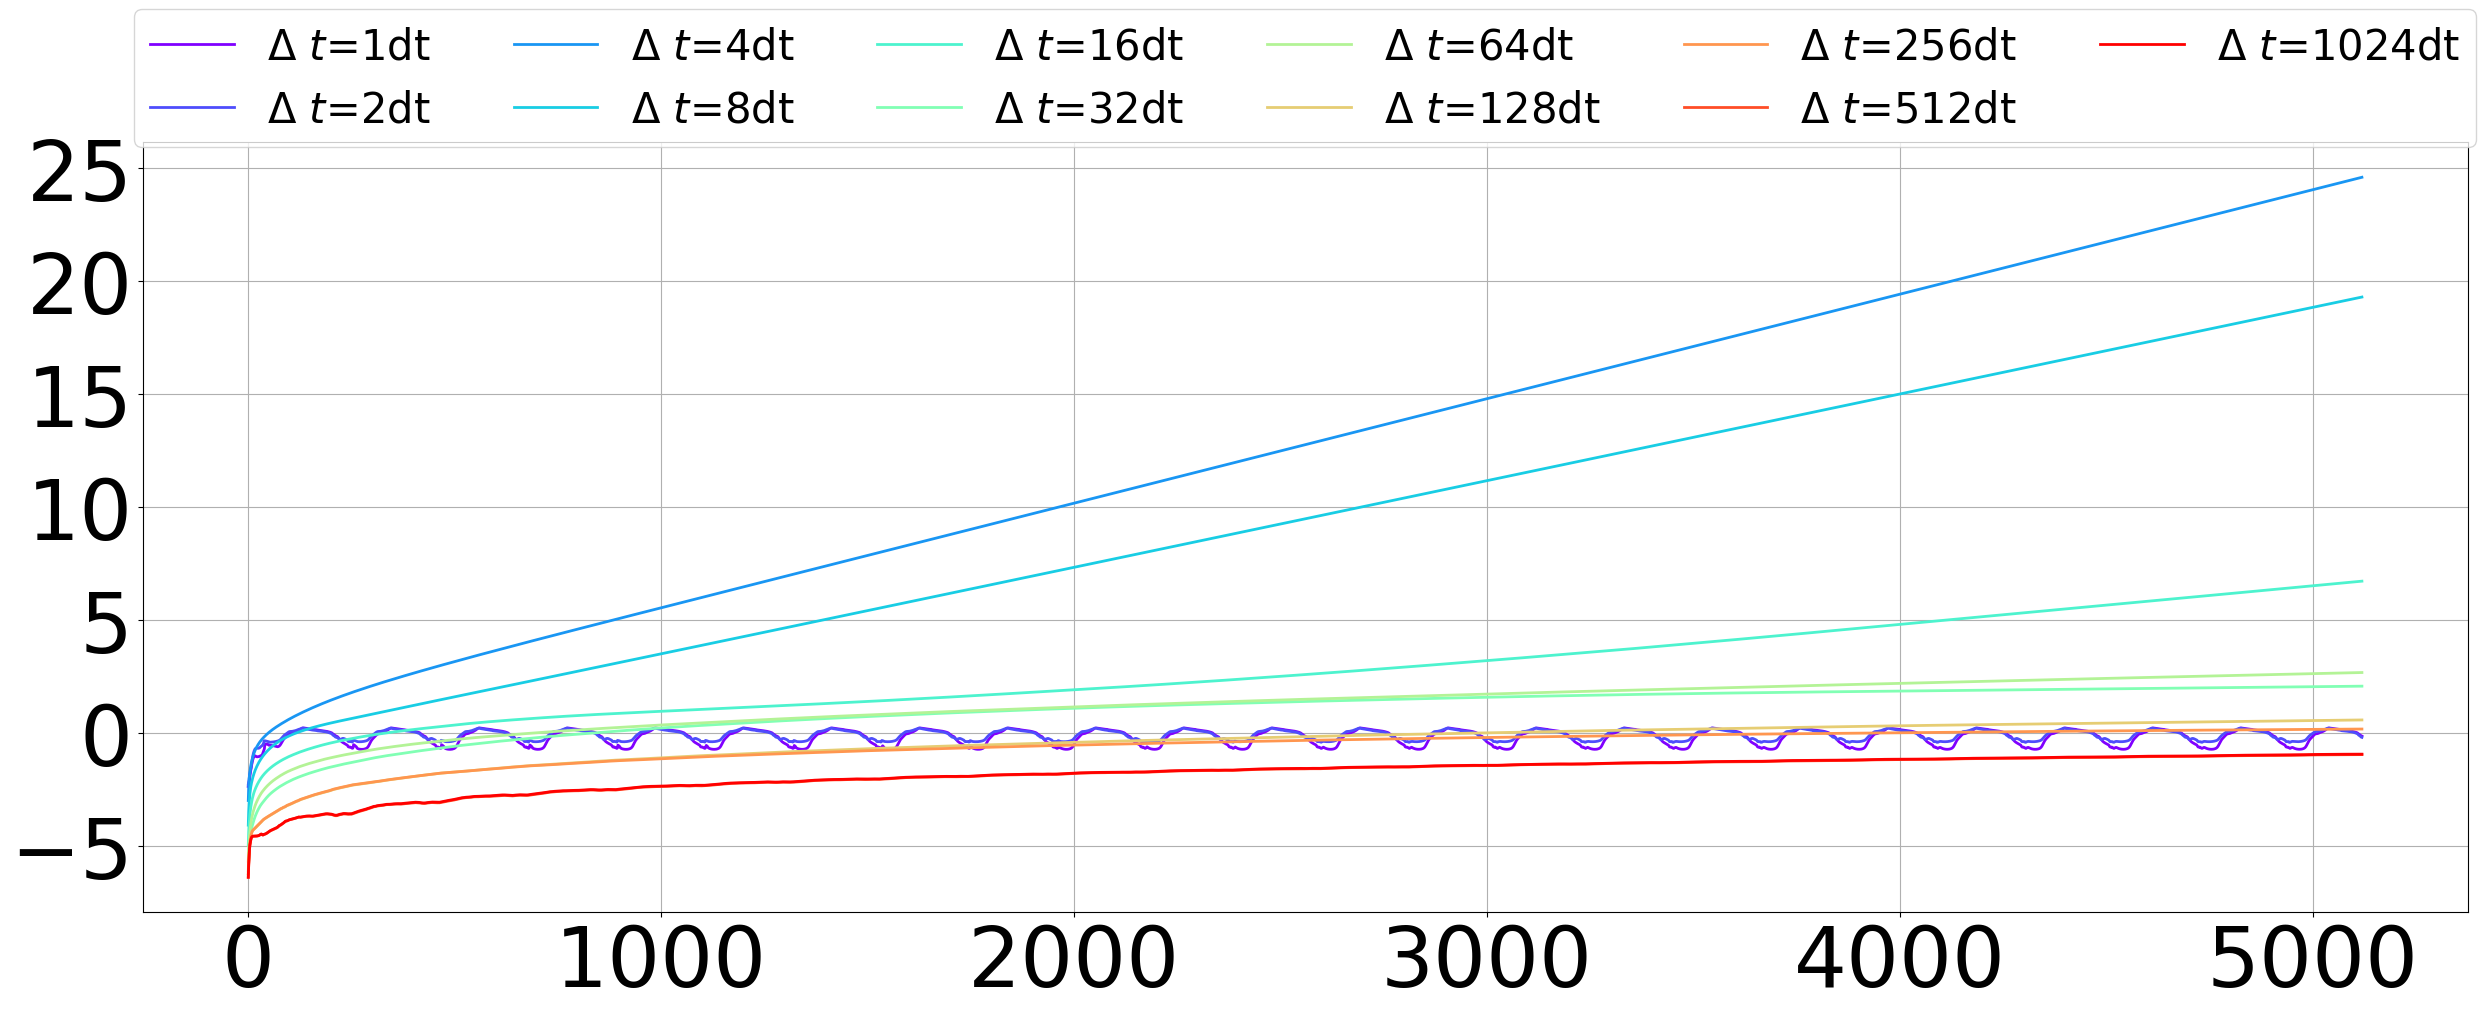

In [63]:
nnerr=list()
norm_uni=list()
mean_pointwise=list()
ks = list(range(11))
colors=iter(plt.cm.rainbow(np.linspace(0, 1, len(ks))))
fig = plt.figure(figsize=(30, 10))
for k in range(len(RN_test_loss)):
    err = RN_test_loss[k]
    mean = err.mean(0).cpu().detach().numpy()
    nnerr.append(mean)
    norm_uni.append(mean.mean())  #mean
    mean_pointwise.append(mean)
    rgb = next(colors)
    plt.plot(np.log10(mean), linestyle='-', color=rgb, linewidth=2, label='$\Delta\ t$={}dt'.format(step_sizes[k]))
    
plt.legend(fontsize=30, loc='upper center', ncol=6, bbox_to_anchor=(0.5, 1.2))
plt.xticks(fontsize=60)
plt.yticks(fontsize=60)
plt.grid()
plt.show()

In [67]:
z_test.shape , z_RN.shape

(torch.Size([10, 5120, 2]), torch.Size([10, 5120, 2]))

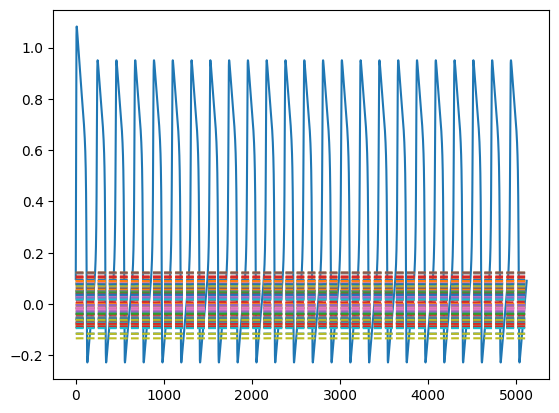

In [78]:
idx=0
# z1=0
# tt=4000
# n_steps=z_test.shape[1]-1
# t=np.linspace(0,(n_steps-1)*dt, n_steps)
# zt=z_test[idx,1:n_steps+1,:].cpu().detach().numpy()
# zhits=z_hits[idx,0:n_steps,:].cpu().detach().numpy()

plt.plot(test_dataAE[idx,:,0].cpu().detach().numpy())
plt.plot(test_reconstructed[idx,:].cpu().detach().numpy(),'--')
# plt.plot(z_RN[idx,:,:].cpu().detach().numpy(),'--')
plt.show()

In [ ]:
n_steps = t_test-1     #test_data.shape[1] - 1
n_steps_val=t_test-1   #val_data.shape[1] - 1
preds_mse = list()
times = list()
z_hits_uni=[]
print('uniscale forecasting...')
for model in models:
    start = time.time()
    z_RN = model.uni_scale_forecast(torch.tensor(z_test[:, 0, :]).float(), n_steps=n_steps).to(device)
    z_hits_uni.append(z_RN)
    end = time.time()
    times.append(end - start)
    preds_mse.append(criterion(torch.tensor(z_test[:, 1:, :]).float(), z_RN).mean(-1))
print('prediction recorded!')

In [42]:
RN_test_loss[0,:10]

tensor([   nan, 0.0388, 0.0700, 0.0990, 0.1246, 0.1039, 0.0516, 0.0192, 0.0049,
        0.0022], device='cuda:0')

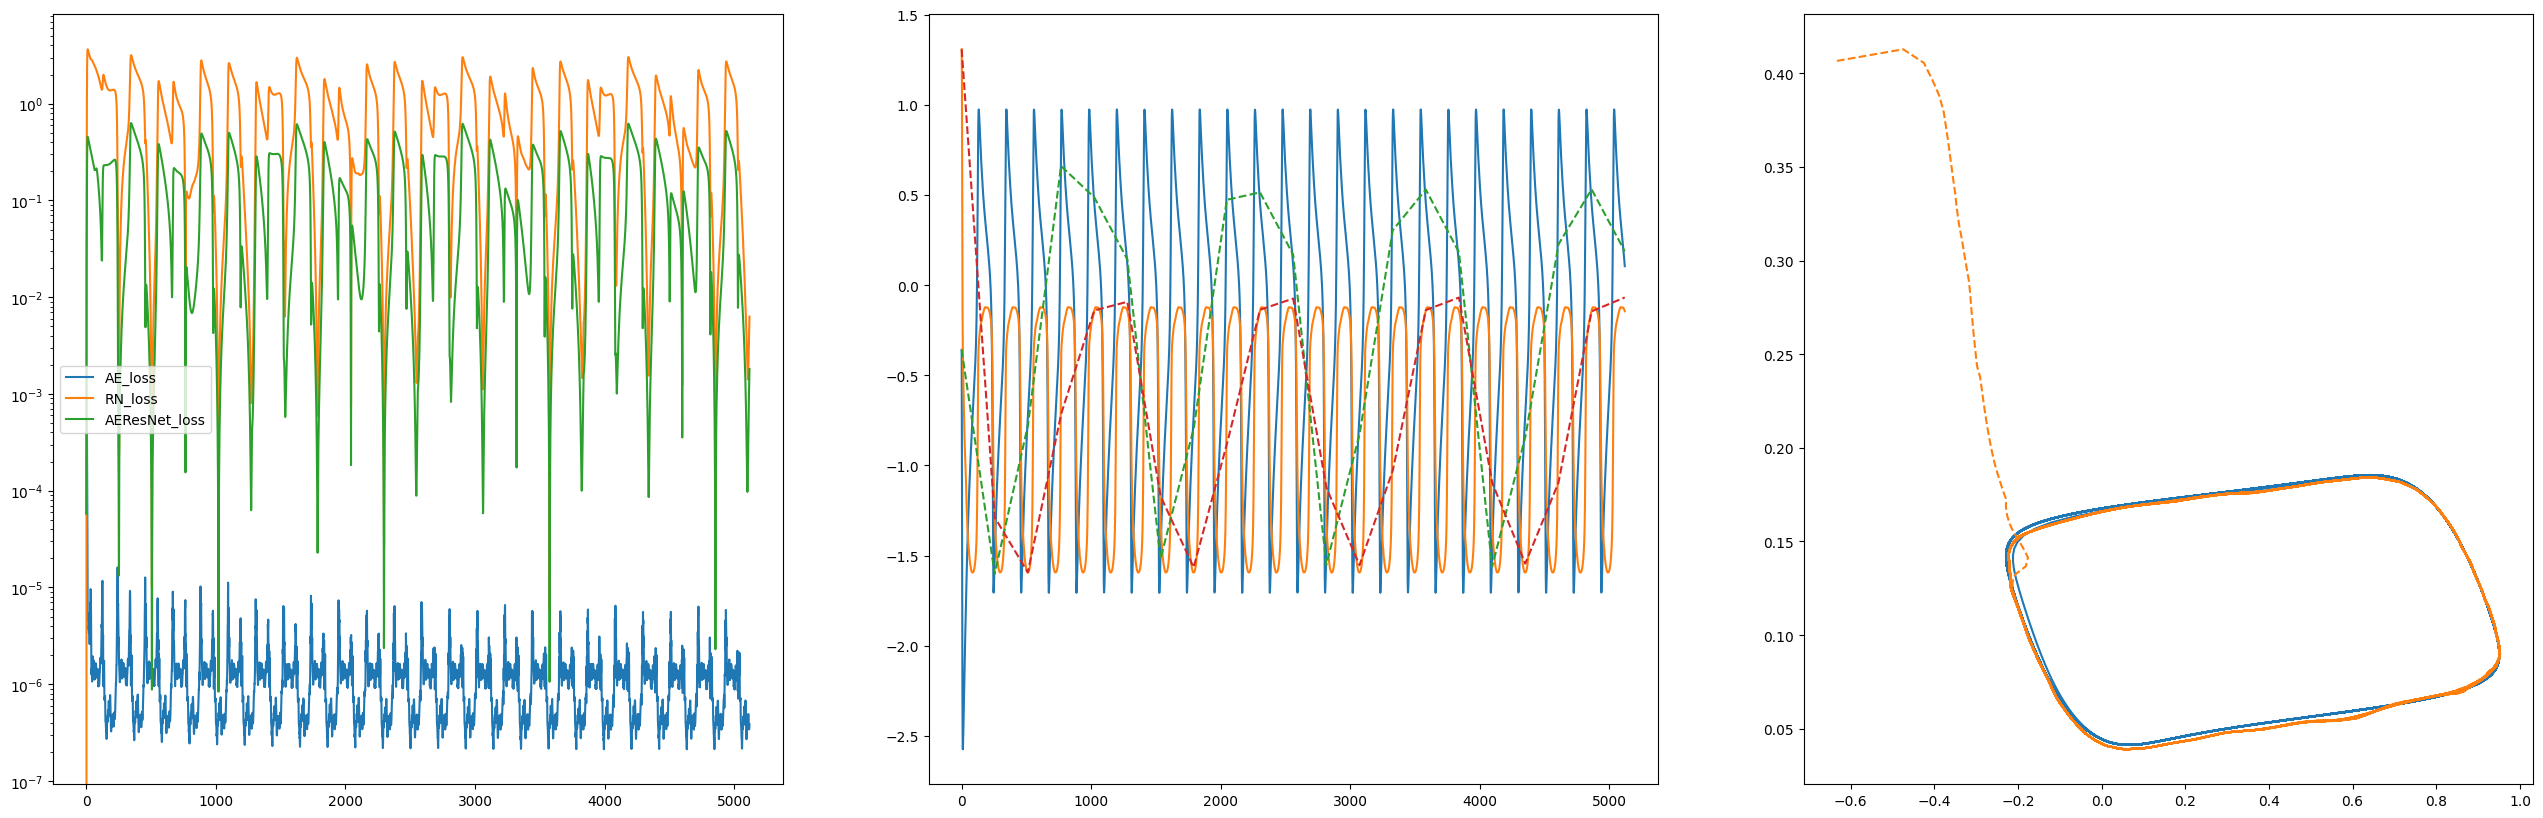

In [82]:
fig = plt.figure(figsize=(32,10))
plt.subplot(1,3,1)
plt.semilogy(AE_test_loss[0,:].cpu().detach().numpy(),label='AE_loss')
plt.semilogy(RN_test_loss[0,:].cpu().detach().numpy(),label='RN_loss')
plt.semilogy(AEResNet_loss[0,:].cpu().detach().numpy(),label='AEResNet_loss')
plt.legend()



plt.subplot(1,3,2)
plt.plot(z_test[0,:,:].cpu().detach().numpy())
plt.plot(z_RN[0,:,:].cpu().detach().numpy(),'--')


plt.subplot(1,3,3)
plt.plot(test_dataAE[1,:,0].cpu().detach().numpy(),test_dataAE[1,:,50].cpu().detach().numpy())
plt.plot(reconstructed[:,0].cpu().detach().numpy(),reconstructed[:,50].cpu().detach().numpy(),'--')
plt.show()

In [93]:
test_reconstructed.shape

torch.Size([10, 5120, 100])

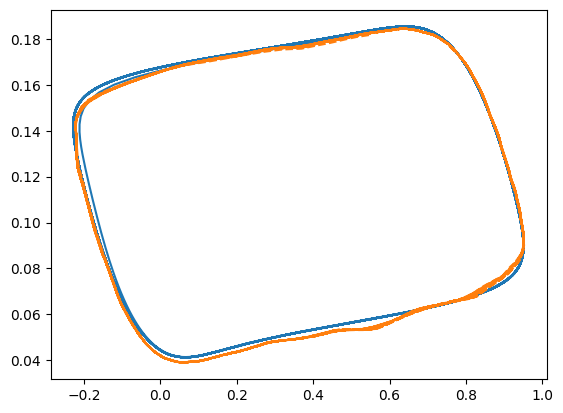

In [105]:
# plt.subplot(1,3,3)
idx=1
plt.plot(test_dataAE[idx,:,0].cpu().detach().numpy(),test_dataAE[idx,:,50].cpu().detach().numpy())
plt.plot(test_reconstructed[idx,:,0].cpu().detach().numpy(),test_reconstructed[idx,:,50].cpu().detach().numpy(),'--')
plt.show()